# C7082 Assignment: Mushroom classification
Student number: 23381200
Date: xx-xx-xx

# Random Forest Classifier training

## Load the data

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from joblib import dump, load

In [1]:
# URL of the raw CSV file in the GitHub repository
url = "https://raw.githubusercontent.com/LientjieColahan/C7082_23381200/refs/heads/main/Model_training/secondary_mushroom_data.csv"


In [5]:

# Load the database
data = pd.read_csv(url, delimiter=';')

# Separate features and target
X = data.drop('class', axis=1)  # Features
y = data['class']  # Target variable

# Convert categorical variables to categorical data type
categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].astype('category')

# Convert target variable to categorical
y = y.astype('category')

# Convert continuous variables to float
continuous_columns = ['cap-diameter', 'stem-height', 'stem-width']
X[continuous_columns] = X[continuous_columns].astype(float)


In [6]:
# Display basic information about the dataset
print("Dataset Info:")
print("\nFeature types:")
print(X.dtypes)
print("\nTarget type:", y.dtype)
print("\nFirst few rows of the features:")
print(X.info())
print(X.head())
print("\nFirst few rows of the target:")
print(y.head())

Dataset Info:
Features shape: (61069, 20)
Target shape: (61069,)

Feature types:
cap-diameter             float64
cap-shape               category
cap-surface             category
cap-color               category
does-bruise-or-bleed    category
gill-attachment         category
gill-spacing            category
gill-color              category
stem-height              float64
stem-width               float64
stem-root               category
stem-surface            category
stem-color              category
veil-type               category
veil-color              category
has-ring                category
ring-type               category
spore-print-color       category
habitat                 category
season                  category
dtype: object

Target type: category

First few rows of the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                -

## Exploratory data analysis

To start check the distribution of the data between edible and poisonous

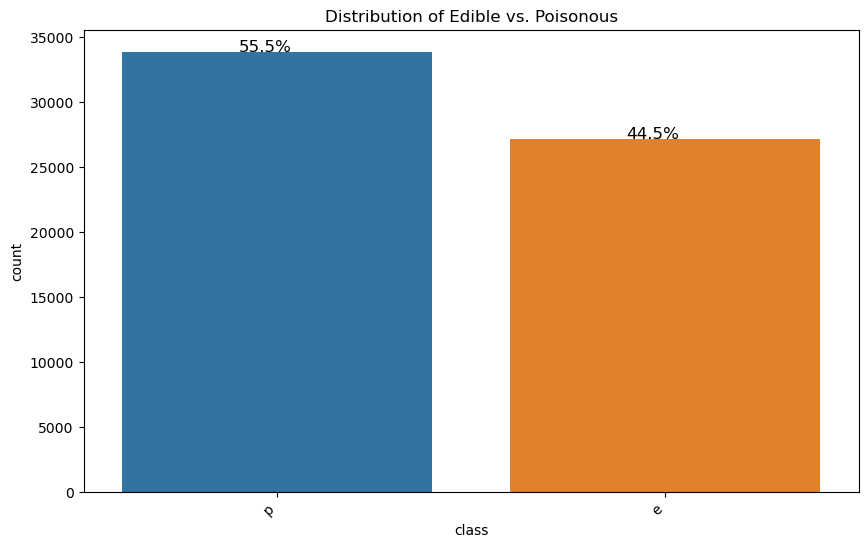

In [7]:
# Check the data spread between edible and poisonous
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='class', data=data)  # Use 'class' column for x-axis
plt.title('Distribution of Edible vs. Poisonous')
plt.xticks(rotation=45, ha='right')

# Calculate percentage for each bar
total = len(data['class'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x_coord = p.get_x() + p.get_width() / 2 - 0.1
    y_coord = p.get_y() + p.get_height()
    ax.annotate(percentage, (x_coord, y_coord), size=12)

plt.show()

The data is reasonably balanced with a 55.55% to 44.5% spread between poisonous and edible.

Next check for missing values in the dataset as these can bias the predictions especially if they match a single output perfectly


In [8]:
# Check for missing values
print("\nMissing values in the dataset:")
missing_values = X.isnull().sum()
missing_percentages = (100 * X.isnull().sum() / len(X)).round(2)
missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Count', 'Percentage'])
missing_table = missing_table[missing_table['Count'] > 0].sort_values('Percentage', ascending=False)
print(missing_table)


Missing values in the dataset:
                   Count  Percentage
veil-type          57892       94.80
spore-print-color  54715       89.60
veil-color         53656       87.86
stem-root          51538       84.39
stem-surface       38124       62.43
gill-spacing       25063       41.04
cap-surface        14120       23.12
gill-attachment     9884       16.18
ring-type           2471        4.05


The dataset has features with a significant number of missing values.

To further investigate the data look at the relationship between the categorical features and how they relate to edible versus poisonous.

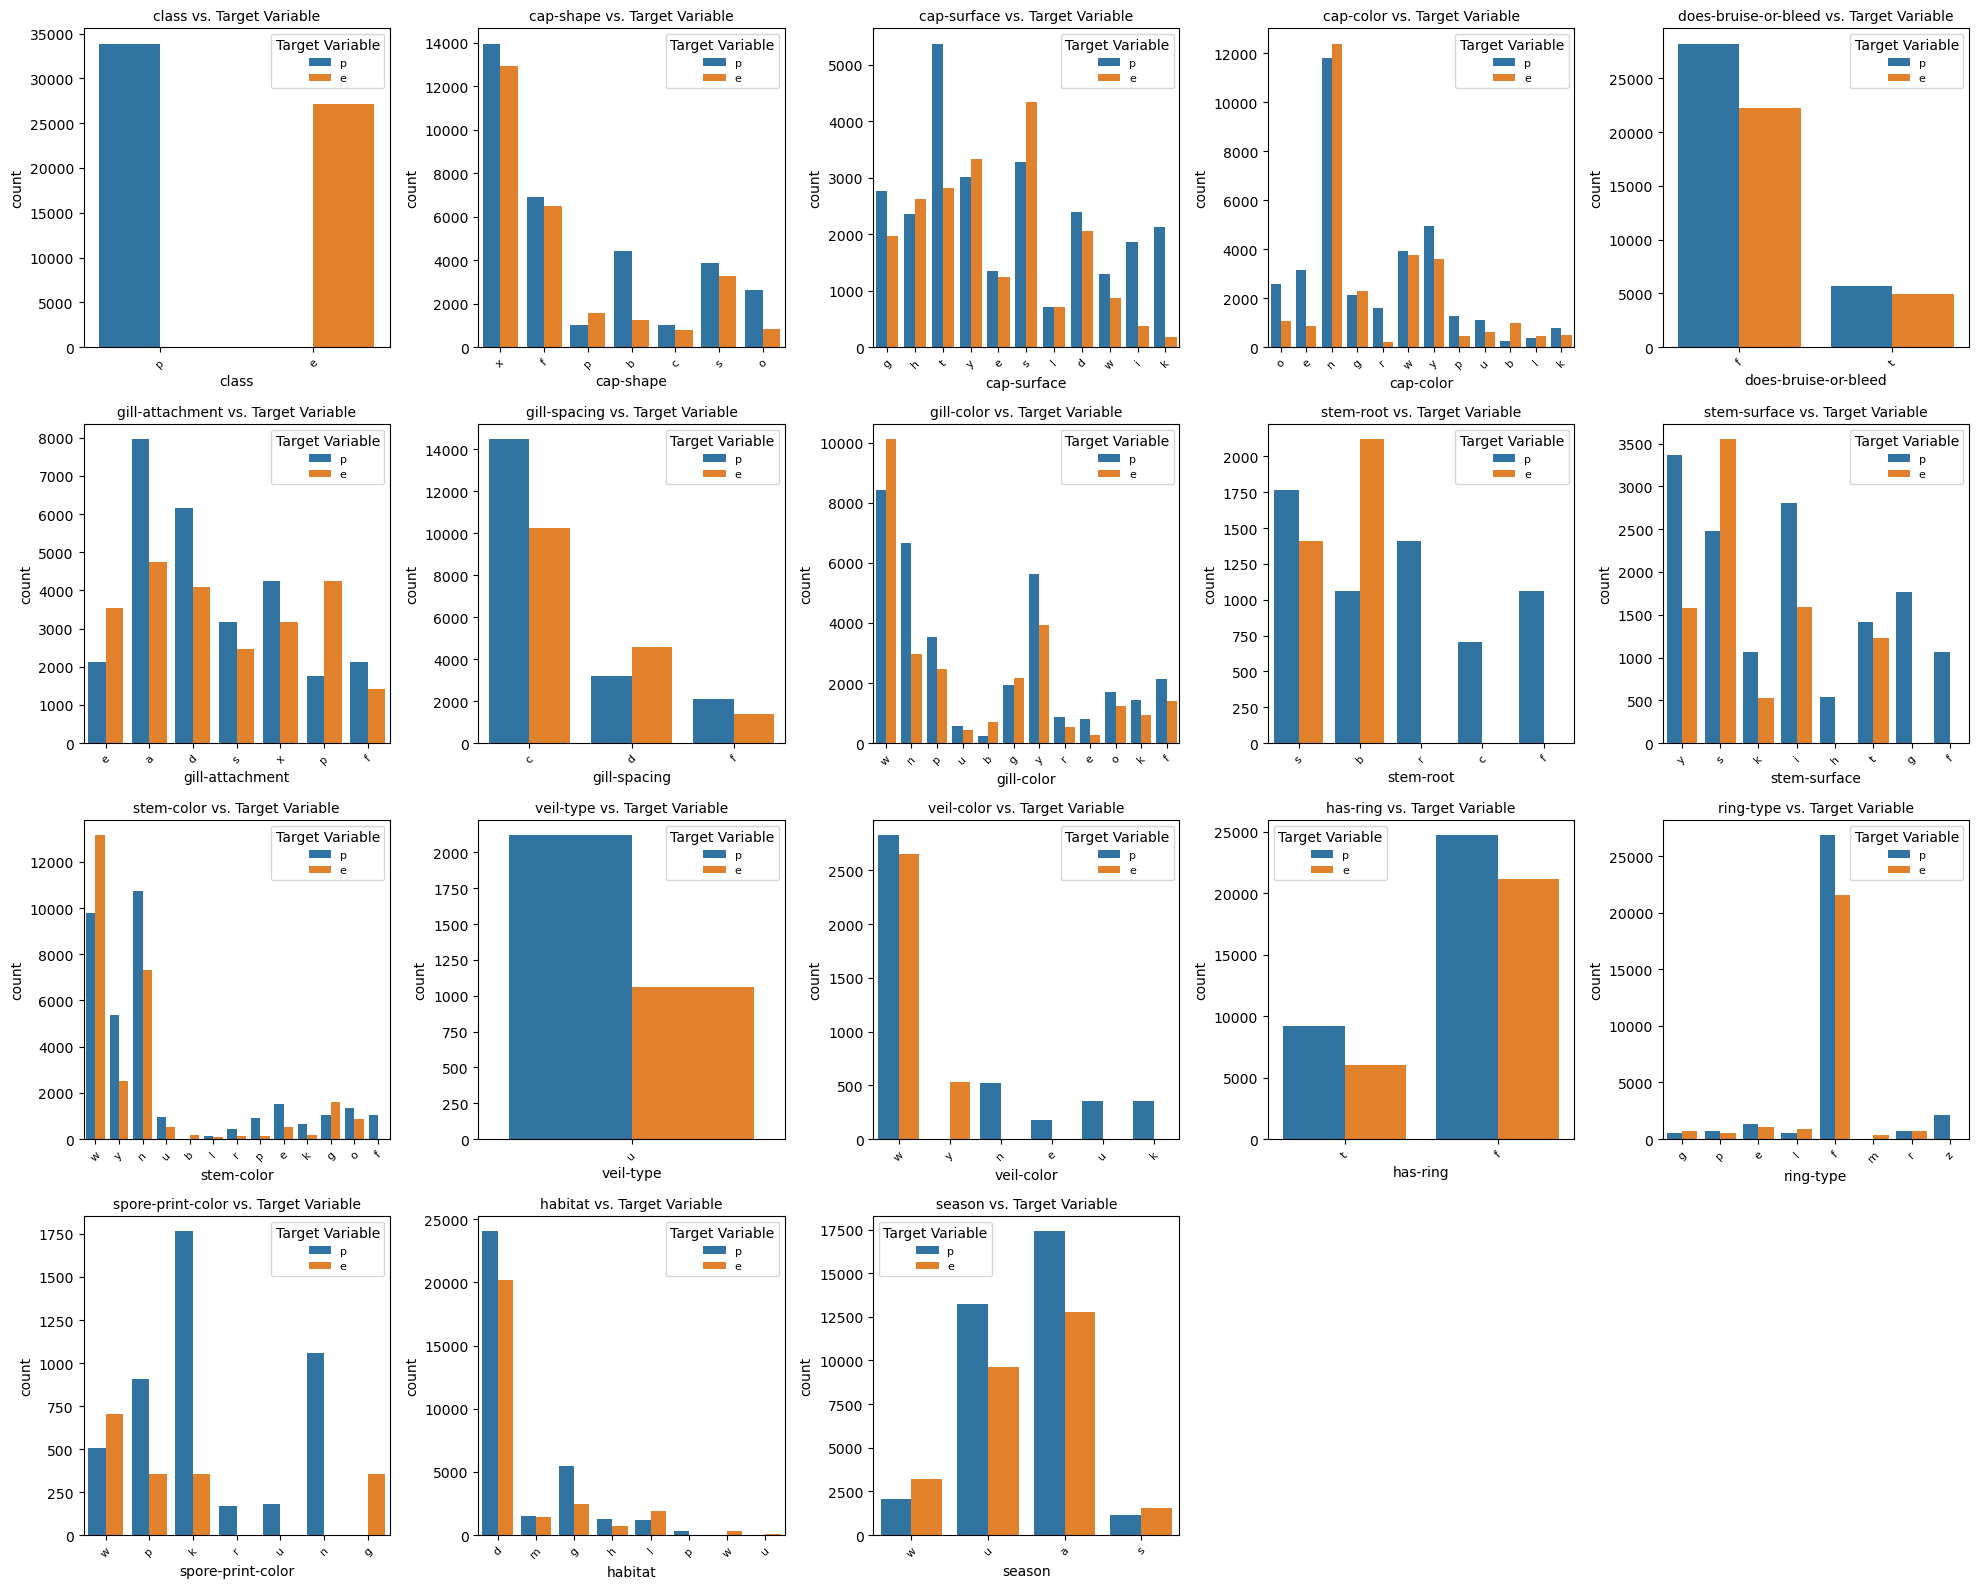

In [9]:
# Explore relationship between categorical features and target variable through bar plot visualisations
# Define the number of rows and columns for the grid
num_rows = 4
num_cols = 5

# Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through categorical columns and plot on subplots
categorical_columns = data.select_dtypes(include=['object']).columns
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue='class', data=data, ax=axes[i])
    axes[i].set_title(f'{column} vs. Target Variable', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].legend(title='Target Variable', fontsize=8)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Hide any unused subplots
for i in range(len(categorical_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Show the plot
plt.show()

Considering the missing values and the relationships between the features and the target it is reasonable to remove:

*   Veil-type as it ha >90% missing values and there is only a single veil type in the dataset
*   Veil-color as it has >85% missing values and only 1 veil colour encodes information for both the values in the target.
* Spore-print-colour as it has >85% missing values and only 3 out of 7 spore print colours encode data for both the values in the target.
* Stem-root as it has >80% missing values and only 2 out of 5 stem root types encode data for both values in the target





In [10]:
# Drop categorical variables which may bias the prediction
X.drop(columns=['veil-type', 'veil-color', 'spore-print-color', 'stem-root'], inplace=True)

**SAY SOMETHING ABOUT THE OTHER MISSING DATA AND HOW RF CAN DEAL WITH MISSING DATA**

## Model training & tuning

In [15]:
# Encode categorical variables
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode target variable (edible=0, poisonous=1)
X_encoded = pd.get_dummies(X)  # One-hot encode categorical features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [18]:
# Train a preliminary RF model to enable feature selection
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Perform feature selection using feature importance
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': rf.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features')
plt.show()

In [20]:
# Hyperparameter tuning using GridSearchCV (edit parameters to experiment)
param_grid = {
    'n_estimators': [10 ,100, 150],  # edit this: number of trees in the forest
    'max_depth': [1, 10, 20],  # edit this: maximum depth of trees
    'min_samples_split': [2, 5, 10],  # edit this: minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5]   # edit this: minimum samples required to be at a leaf node
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=8, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 81 candidates, totalling 648 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=1, min_samples_leaf=1, min_

GridSearchCV(cv=8, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 10, 20],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 100, 150]},
             scoring='accuracy', verbose=2)

In [24]:
# Best parameters and model from GridSearchCV
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [25]:
# Save the best model using joblib
dump(best_rf_model, 'C:/Users/colah/OneDrive/Documents/GitHub/C7082_23381200/Assignment/best_rf_model.joblib') 

['C:/Users/colah/OneDrive/Documents/GitHub/C7082_23381200/Assignment/best_rf_model.joblib']

## Model evaluation

In [26]:
# Evaluate model performance on test set
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



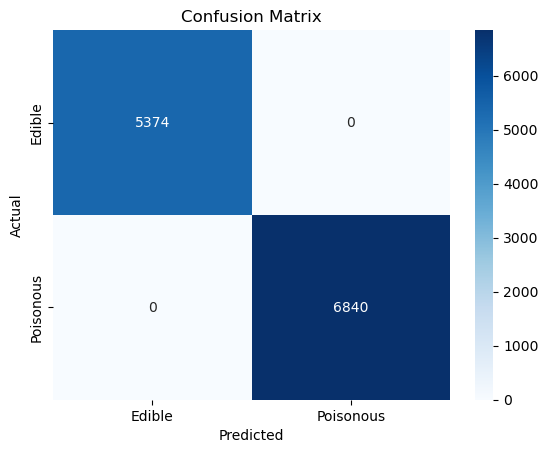

In [27]:
# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

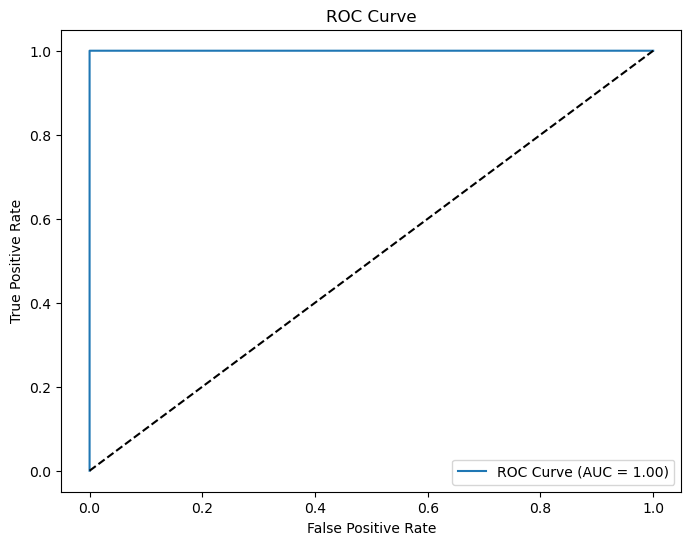

In [28]:
# ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Code to load model and test data on it


In [32]:
#from joblib import load
from sklearn.metrics import accuracy_score

# Load the saved model
#loaded_model = load('best_rf_model.joblib')

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

Accuracy on test data: 1.00
